In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil

In [ ]:
# matplotlib settings to match LaTeX fonts and style
latex_path = shutil.which("latex")
print("LaTeX found at:", latex_path if latex_path else "Not found in PATH")

mpl.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",  # Computer Modern serif
        "text.latex.preamble": r"\usepackage[T1]{fontenc}\usepackage{amsmath,amssymb,bm}",
        "axes.labelsize": 9,  # adjust to match \small or \normalsize
        "font.size": 9,
        "legend.fontsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
    }
)


def set_size(width_pt=455, fraction=1, aspect=0.62):
    """Set figure dimensions to fit LaTeX doc."""
    inches_per_pt = 1 / 72.27
    width_in = width_pt * inches_per_pt * fraction
    height_in = width_in * aspect
    return (width_in, height_in)

LaTeX found at: /Library/TeX/texbin/latex


In [4]:
def get_df(model, table, ra, seed):
    path = f"results/{model}/{table}/ra{ra}-{seed}.csv"
    if not os.path.exists(path):
        return None
    df = pd.read_csv(path)
    df["model"] = model
    df["ra"] = ra
    df["seed"] = seed
    return df


models = ["3d-lran", "3d-fno", "3d-lstm"]
ras = [2500]
seeds = [0, 1, 2]

metric = "nrsse"

# collect all data into one big DataFrame
df = pd.concat(
    [get_df(m, "metrics", r, seed) for m in models for r in ras for seed in seeds],
    ignore_index=True,
)


def model2name(model):
    if model == "3d-lran":
        return "LRAN"
    elif model == "3d-fno":
        return "FNO"
    elif model == "3d-lstm":
        return "AE+LSTM"
    else:
        return model

# Prediction Error vs Ra

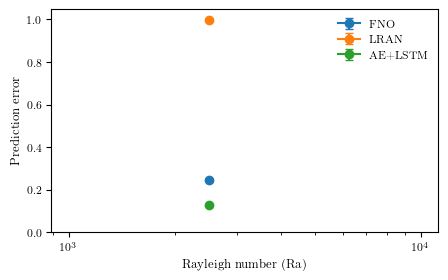

In [4]:
# TODO debug filter; filter out steps above 30
# df = df[df["step"] <= 30]
# df = df[df["ra"] >= 300000]

# 1) collapse each run (model, ra, seed) to a single scalar: mean error over all samples & timesteps
per_run = (
    df.groupby(["model", "ra", "seed"], as_index=False)[metric]
    .mean()
    .rename(columns={metric: "run_mean"})
)

# 2) aggregate across seeds (between-run variability)
summary = (
    per_run.groupby(["model", "ra"])["run_mean"]
    .agg(mu="mean", sigma="std", n_runs="count", best="min", median="median")
    .reset_index()
)

# standard error and 95% CI for convenience
# summary["se"] = summary["sigma"] / np.sqrt(summary["n_runs"]).replace(0, np.nan)
# summary["ci95"] = 1.96 * summary["se"]

# nice sort by Ra (numeric) and model
summary = summary.sort_values(["model", "ra"]).reset_index(drop=True)
fig, ax = plt.subplots(figsize=set_size(455, fraction=0.7))

for model, sub in summary.groupby("model"):
    x = sub["ra"].values
    y = sub["mu"].values
    yerr = sub["sigma"].values
    ax.errorbar(x, y, yerr=yerr, marker="o", capsize=3, label=model2name(model))

ax.set_xlabel(r"Rayleigh number ($\mathrm{Ra}$)")
ax.set_ylabel(r"Prediction error")
ax.set_xscale("log")
ax.set_ylim(bottom=0)
ax.legend(frameon=False)
fig.tight_layout(pad=0.5)

# --- Save as vector PDF for LaTeX ---
fig.savefig("figs/error_vs_ra.pdf")

# Prediction Error vs Time in Sequence

       model  step        mu     sigma
99    3d-fno    99  0.486706  0.006852
199  3d-lran    99  1.080729  0.016966
299  3d-lstm    99  0.215123       NaN


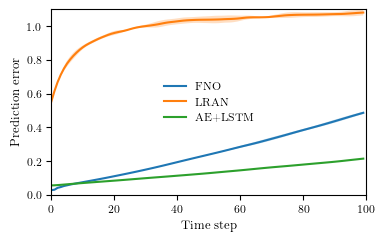

In [18]:
RA = 2500

d = df.copy()
d = d[d["ra"] == RA]

# 1) Per-run, per-time mean and std over samples (within-run stats)
# count is helpful for pooled std later
per_run_time = (
    d.groupby(["model", "seed", "step"])[metric].agg(run_mean="mean").reset_index()
)

# 2) Aggregate across seeds at each time
across = (
    per_run_time.groupby(["model", "step"])["run_mean"]
    .agg(mu="mean", sigma="std")
    .reset_index()
    .sort_values(["model", "step"])
    .reset_index(drop=True)
)

print(across[across["step"] == 99])

fig, ax = plt.subplots(figsize=set_size(455, fraction=0.6))

for model, sub in across.groupby("model"):
    x = sub["step"].values
    mu = sub["mu"].values
    sig = sub["sigma"].values
    plt.plot(x, mu, label=model2name(model))
    plt.fill_between(x, mu - sig, mu + sig, alpha=0.25)

ax.set_xlabel(r"Time step")
ax.set_ylabel(r"Prediction error")
# ax.set_title(rf"Rayleigh number ($\mathrm{{Ra}}={RA:.0e}$)")
ax.set_ylim(bottom=0, top=1.1)
ax.set_xlim(left=0, right=100)
ax.legend(frameon=False)
fig.tight_layout(pad=0.5)

# --- Save as vector PDF for LaTeX ---
fig.savefig(f"figs/error_vs_time_ra{RA}.pdf")

## Nusselt Number

In [5]:
df_nu = pd.concat(
    [get_df(m, "nusselt", r, seed) for m in models for r in ras for seed in seeds],
    ignore_index=True,
)

RA = 2500
df_nu = df_nu[df_nu["ra"] == RA]

print(df_nu)

        batch_idx  step   nu_pred  nu_target    model    ra  seed    idx
0             0.0     0  0.015315   0.021064  3d-lran  2500     0    NaN
1             0.0     1  0.015906   0.021266  3d-lran  2500     0    NaN
2             0.0     2  0.016202   0.021460  3d-lran  2500     0    NaN
3             0.0     3  0.016431   0.021620  3d-lran  2500     0    NaN
4             0.0     4  0.016584   0.021724  3d-lran  2500     0    NaN
...           ...   ...       ...        ...      ...   ...   ...    ...
102995        NaN    95  0.021199   0.020725  3d-lstm  2500     0  999.0
102996        NaN    96  0.021226   0.020696  3d-lstm  2500     0  999.0
102997        NaN    97  0.021242   0.020691  3d-lstm  2500     0  999.0
102998        NaN    98  0.021288   0.020716  3d-lstm  2500     0  999.0
102999        NaN    99  0.021382   0.020776  3d-lstm  2500     0  999.0

[103000 rows x 8 columns]


      batch_idx  step   nu_pred  nu_target   model    ra  seed  idx
1500        0.0     0  0.020853   0.021064  3d-fno  2500     0  NaN
1501        0.0     1  0.020955   0.021266  3d-fno  2500     0  NaN
1502        0.0     2  0.020975   0.021460  3d-fno  2500     0  NaN
1503        0.0     3  0.021035   0.021620  3d-fno  2500     0  NaN
1504        0.0     4  0.020979   0.021724  3d-fno  2500     0  NaN
...         ...   ...       ...        ...     ...   ...   ...  ...
1595        0.0    95  0.020651   0.021762  3d-fno  2500     0  NaN
1596        0.0    96  0.020575   0.021545  3d-fno  2500     0  NaN
1597        0.0    97  0.020450   0.021307  3d-fno  2500     0  NaN
1598        0.0    98  0.020299   0.021061  3d-fno  2500     0  NaN
1599        0.0    99  0.020140   0.020818  3d-fno  2500     0  NaN

[100 rows x 8 columns]


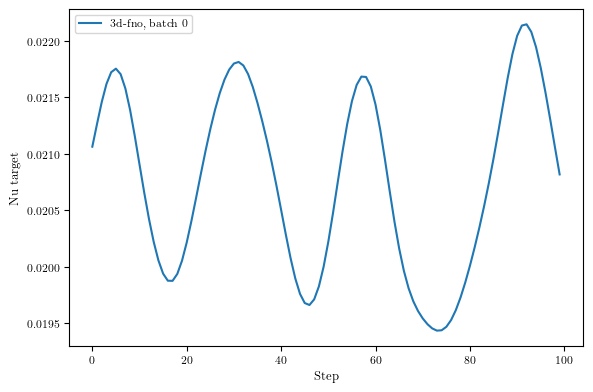

In [13]:
# Example: filter for model="2d-fno" and batch_idx=0
model_name = "3d-fno"
batch_id = 0

df_filtered = df_nu[
    (df_nu["model"] == model_name)
    & (df_nu["batch_idx"] == batch_id)
    & (df_nu["seed"] == 0)
]
print(df_filtered)

plt.figure(figsize=(6, 4))
plt.plot(
    df_filtered["step"],
    df_filtered["nu_target"],
    label=f"{model_name}, batch {batch_id}",
)
plt.xlabel("Step")
plt.ylabel("Nu target")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=set_size(455, fraction=0.6))

for model, sub in across.groupby("model"):
    x = sub["step"].values
    mu = sub["mu"].values
    sig = sub["sigma"].values
    plt.plot(x, mu, label=model2name(model))
    plt.fill_between(x, mu - sig, mu + sig, alpha=0.25)

ax.set_xlabel(r"Time step")
ax.set_ylabel(r"Prediction error")
# ax.set_title(rf"Rayleigh number ($\mathrm{{Ra}}={RA:.0e}$)")
ax.set_ylim(bottom=0, top=1.1)
ax.set_xlim(left=0, right=100)
ax.legend(frameon=False)
fig.tight_layout(pad=0.5)

# --- Save as vector PDF for LaTeX ---
fig.savefig(f"figs/error_vs_time_ra{RA}.pdf")